In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, roc_auc_score, roc_curve
)


In [10]:
def prepare_df(bots_file, human_file, add_features=True):
    df_bots = pd.read_csv(bots_file); df_bots["bot"] = 1
    df_hum  = pd.read_csv(human_file); df_hum["bot"] = 0
    df = pd.concat([df_bots, df_hum], ignore_index=True, sort=False)

    if add_features:
        # Convert all numeric safely
        for c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce') 

        # Derived features
        df['bytes_per_request'] = df['Total_Bytes'] / (df['Total_requests'] + 1e-6)
        df['get_post_ratio'] = df['Total_GET_requests'] / (df['Total_POST_requests'] + 1e-6)
        df['avg_req_per_sec'] = df['Total_requests'] / (df['Session_time'] + 1e-6)
        df['seq_ratio'] = df['Max_sequential_request'] / (df['Max_requests_per_page'] + 1e-6)
        df['resource_ratio'] = (
            df.get('per_image_requests',0) +
            df.get('per_css_request',0) +
            df.get('per_js_requests',0)
        )
        df['Total_Bytes_log'] = np.log1p(df['Total_Bytes'].clip(lower=0))
        df['Session_time_log'] = np.log1p(df['Session_time'].clip(lower=0))
        df['Average_requests_per_page_log'] = np.log1p(df['Average_requests_per_page'].clip(lower=0))

    # Replace infinities or NaNs with 0
    df = df.replace([np.inf, -np.inf], np.nan).fillna(0)

    drop_cols = ['session_id', 'bot']
    feature_cols = [c for c in df.columns if c not in drop_cols]
    X = df[feature_cols].copy()
    y = df['bot'].values
    return df, X, y, feature_cols


In [ ]:
class CSVM():
    svm = SVC(kernel='rbf', C=35, gamma=0.04, class_weight='balanced', probability=True, random_state=42)

    def fit(self,X_train_s, y_train):
        self.svm.fit(X_train_s, y_train)
    def predict(self,X_test_s):
        y_pred = self.svm.predict(X_test_s)
        return y_pred
    def predict_proba(self,X_test_s):
        y_prob = self.svm.predict_proba(X_test_s)
        return y_prob

    

In [12]:
def run_simple_svm(bots_file, human_file, title="Dataset"):
    print(f"\n===== Running SVM on {title} =====")
    df, X, y, feature_cols = prepare_df(bots_file, human_file, add_features=True)
    print("Data shape:", X.shape, "Bots:", int((y==1).sum()), "Humans:", int((y==0).sum()))

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X.values, y, test_size=0.2, stratify=y, random_state=42
    )

    # Scale features
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # Train SVM (tuned params)
    svm = CSVM()
    svm.fit(X_train_s, y_train)

    # Predict + metrics
    y_pred = svm.predict(X_test_s)
    y_prob = svm.predict_proba(X_test_s)[:,1]

    acc = accuracy_score(y_test, y_pred)
    print(f"\n{title} — Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{title} — Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title} — ROC Curve")
    plt.legend()
    plt.show()

    print(f"{title} — ROC AUC: {auc:.4f}")
    return {"accuracy": acc, "auc": auc}



===== Running SVM on Normal Dataset =====
Data shape: (814, 25) Bots: 424 Humans: 390

Normal Dataset — Accuracy: 0.8896
              precision    recall  f1-score   support

           0     0.8750    0.8974    0.8861        78
           1     0.9036    0.8824    0.8929        85

    accuracy                         0.8896       163
   macro avg     0.8893    0.8899    0.8895       163
weighted avg     0.8899    0.8896    0.8896       163



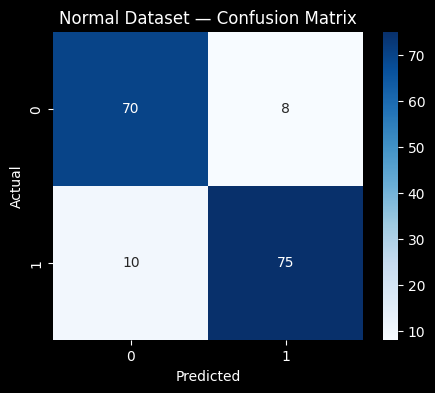

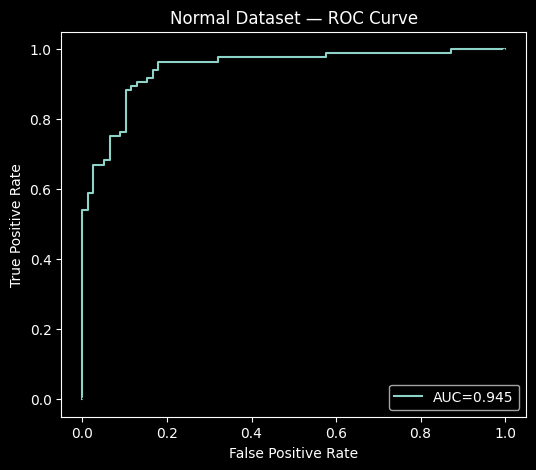

Normal Dataset — ROC AUC: 0.9454

===== Running SVM on No_MV_Req Dataset =====
Data shape: (813, 25) Bots: 424 Humans: 389

No_MV_Req Dataset — Accuracy: 0.8344
              precision    recall  f1-score   support

           0     0.8592    0.7821    0.8188        78
           1     0.8152    0.8824    0.8475        85

    accuracy                         0.8344       163
   macro avg     0.8372    0.8322    0.8331       163
weighted avg     0.8362    0.8344    0.8337       163



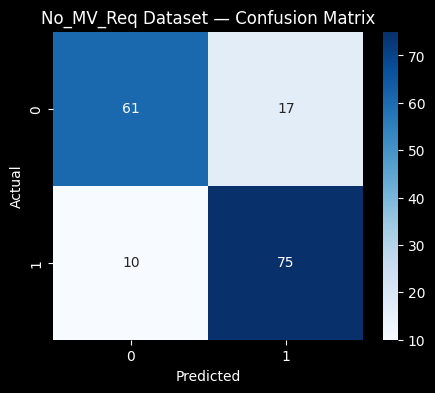

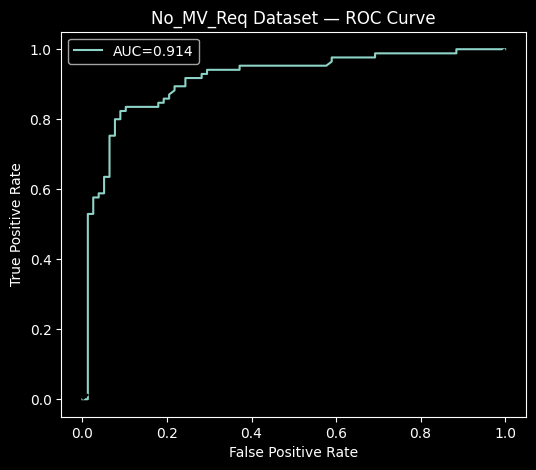

No_MV_Req Dataset — ROC AUC: 0.9136


In [ ]:
# res_normal = run_simple_svm("../parsed_data/bots.csv", "../parsed_data/human.csv", title="Normal Dataset")
# res_nomv   = run_simple_svm("../parsed_data/bots_no_mv_req.csv", "../parsed_data/human_no_mv_req.csv", title="No_MV_Req Dataset")
